# <고군산군도 카페 리뷰 토픽모델링과 워드클라우드>

### 버전 호환문제 등으로 부득이하게 Google Colab을 활용한 코드를 제출합니다.

## 라이브러리와 폰트 가져오기

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab

## 부정리뷰 긍정리뷰 Load

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/데청캠

/content/gdrive/My Drive/데청캠


In [ ]:
neg = pd.read_csv('neg.csv').set_index('Unnamed: 0').rename_axis(index=None)

In [ ]:
pos = pd.read_csv('pos.csv').set_index('Unnamed: 0').rename_axis(index=None)

## 형태소 분석기의 사용자사전 정의

In [ ]:
cd /content/mecab-ko-dic-2.1.1-20180720

/content/mecab-ko-dic-2.1.1-20180720


In [ ]:
ls user-dic

nnp.csv  person.csv  place.csv  README.md


In [ ]:
# 각각 명사 사람 장소를 등록할 수 있는 csv

### 종성판별기

In [ ]:
!pip install jamo

In [ ]:
from jamo import h2j, j2hcj

def get_jongsung_TF(sample_text):
  sample_text_list = list(sample_text) 
  last_word = sample_text_list[-1] 
  last_word_jamo_list = list(j2hcj(h2j(last_word))) 
  last_jamo = last_word_jamo_list[-1] 

  jongsung_TF = "T" 

  if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']: 
    jongsung_TF = "F" 
    
  return jongsung_TF

### 사용자사전 단어추가

In [ ]:
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f:
  nnp = f.readlines()

add_dict = ['라파르', '선유도', '고군산군도', '불편', '손님','카페라파르','환야갤러리','다타고','도겸찻집',\
            '그섬애','카페마실','바다향기카페','장자스토리','호떡당','전망좋은집','아이리스커피', '한라봉', '에이드', '비쌈']

for w in add_dict:
  jongsung = get_jongsung_TF(w)
  nnp.append( '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(w,jongsung,w) )

with open("./user-dic/nnp.csv", 'w', encoding='utf-8') as f:
  for line in nnp:
    f.write(line)

with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f:
  nnp = f.readlines()
nnp

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '라파르,,,,NNP,*,F,라파르,*,*,*,*,*\n',
 '선유도,,,,NNP,*,F,선유도,*,*,*,*,*\n',
 '고군산군도,,,,NNP,*,F,고군산군도,*,*,*,*,*\n',
 '불편,,,,NNP,*,T,불편,*,*,*,*,*\n',
 '손님,,,,NNP,*,T,손님,*,*,*,*,*\n',
 '카페라파르,,,,NNP,*,F,카페라파르,*,*,*,*,*\n',
 '환야갤러리,,,,NNP,*,F,환야갤러리,*,*,*,*,*\n',
 '다타고,,,,NNP,*,F,다타고,*,*,*,*,*\n',
 '도겸찻집,,,,NNP,*,T,도겸찻집,*,*,*,*,*\n',
 '그섬애,,,,NNP,*,T,그섬애,*,*,*,*,*\n',
 '카페마실,,,,NNP,*,T,카페마실,*,*,*,*,*\n',
 '바다향기카페,,,,NNP,*,T,바다향기카페,*,*,*,*,*\n',
 '장자스토리,,,,NNP,*,F,장자스토리,*,*,*,*,*\n',
 '호떡당,,,,NNP,*,T,호떡당,*,*,*,*,*\n',
 '전망좋은집,,,,NNP,*,T,전망좋은집,*,*,*,*,*\n',
 '아이리스커피,,,,NNP,*,F,아이리스커피,*,*,*,*,*\n',
 '한라봉,,,,NNP,*,T,한라봉,*,*,*,*,*\n',
 '에이드,,,,NNP,*,F,에이드,*,*,*,*,*\n',
 '비쌈,,,,NNP,*,T,비쌈,*,*,*,*,*\n']

In [ ]:
!bash ./tools/add-userdic.sh

In [ ]:
!make install

In [ ]:
cd /content/gdrive/My Drive/데청캠

/content/gdrive/My Drive/데청캠


## 부정어 (업로드, 다운로드 및) 전처리

In [ ]:
neg

,LABEL-1,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
1,https://lh3.googleusercontent.com/a-/AOh14Gj5K...,J-do SONG,지역 가이드,・리뷰 424개,1년 전,동네 유일의 커피숍인가요 몇개 있을법한데 한참 찾아 헤매여봐도 안보이더군요 양으로...,카페드선유,0.278249,부정
3,https://lh3.googleusercontent.com/a/AATXAJzwA8...,Seung Hun Lee,지역 가이드,・리뷰 25개,3달 전,커피맛이 % 부족합니다,카페드선유,0.131014,부정
6,https://lh3.googleusercontent.com/a-/AOh14GgUj...,백진영,지역 가이드,・리뷰 502개,1달 전,커피맛도 ㅠ\n서비스도 ㅠ,카페드선유,0.045174,부정
15,https://lh3.googleusercontent.com/a-/AOh14GgX6...,bs park,지역 가이드,・리뷰 191개,11달 전,그 카페근처에 짬뽕집 정말 정말 맛없음 서비스 개떡 그 동네도 두번다시 가기 싫어졌음,카페드선유,0.008588,부정
18,https://lh3.googleusercontent.com/a/AATXAJypHK...,최현주,지역 가이드,・리뷰 92개,3년 전,바다 보이는 커피숍 입니다\n부부간에 운영하시는듯 사람이 만을땐\n조금 늦게 나...,카페드선유,0.037293,부정
...,...,...,...,...,...,...,...,...,...
1546,NaN,NaN,지역 가이드,NaN,NaN,NaN,NaN,0.244035,부정
1547,NaN,NaN,지역 가이드,NaN,NaN,Good,NaN,0.372139,부정
1550,NaN,NaN,지역 가이드,NaN,NaN,복돼지 빵이 방금했다고 했는데ㅜㅜ다 식고 빵도 너무 두껍고ㅜㅜ먹다 말았어요ㅠ장자도에...,NaN,0.059813,부정
1573,NaN,NaN,지역 가이드,NaN,NaN,바로구워주지않아서 별루요\n식은호떡 데워주는 기분이요\n이른시간도 아닌데 청소도 덜...,NaN,0.006857,부정


In [ ]:
#불용어 제거, token화 시키기
def text_preprocessing(text_list):
    
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게','또는','및','의','로'] #불용어 설정
    stopwords = stopwords + '합니다 습니다 입니다 세요 예요 어요 네요 해서 했 았 시 는데 거 기 어요 아요 어 되 아 그 음 null nan 에서 것 면 만\
    요 는데 은데 에요 셨 할 며 함 진짜 정말 지만 인데 으로 그리고 어서 면서 라고 아서 으면 까지 인지 으나 이나 구요 카페 커피 선유도 선유 해요 넘 너무 곳 데 서 었 점 였 오 나 라\
    있 안 좋 실 갔 덜 아니 않 안 주'.split() #추가 불용어
    tokenizer = Mecab() #형태소 분석기 
    token_list = []
    
    for content in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', str(content)) #한글이랑 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        token = [t for t in token if t not in stopwords and type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)     
    
    return token_list, tokenizer
#token_list에는 쪼개진 단어(token)들이 들어있음

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import konlpy
from konlpy.tag import Mecab
import re

In [ ]:
neg = neg['review']

In [ ]:
review_neg, mecab = text_preprocessing(neg)
review_neg = list(filter(None, review_neg))

## 토픽모델(LDA)을 이용한 부정어 토픽 분류

In [ ]:
pip install --upgrade tomotopy

In [ ]:
import tomotopy as tp 

num_k=3

model = tp.LDAModel(k=num_k, alpha=0.1, eta=0.01, min_cf=5)
# LDAModel을 생성합니다.
# 토픽의 개수(k)는 20개, alpha 파라미터는 0.1, eta 파라미터는 0.01
# 전체 말뭉치에 5회 미만 등장한 단어들은 제거할 겁니다.
 
# 다음 구문은 input_file.txt 파일에서 한 줄씩 읽어와서 model에 추가합니다.
for i in range(len(review_neg)):
    model.add_doc(review_neg[i]) # 공백 기준으로 단어를 나누어 model에 추가합니다.
#    if i % 10 == 0: print('Document #{} has been loaded'.format(i))
 
# model의 num_words나 num_vocabs 등은 train을 시작해야 확정됩니다.
# 따라서 이 값을 확인하기 위해서 train(0)을 하여 실제 train은 하지 않고
# 학습 준비만 시킵니다.
# num_words, num_vocabs에 관심 없다면 이부분은 생략해도 됩니다.
model.train(0) 
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
# 다음 구문은 train을 총 200회 반복하면서, 
# 매 단계별로 로그 가능도 값을 출력해줍니다.
# 혹은 단순히 model.train(200)으로 200회 반복도 가능합니다.
for i in range(200):
#    print('Iteration {}\tLL per word: {}'.format(i, model.ll_per_word))
    model.train(1)
 
# 학습된 토픽들을 출력해보도록 합시다.
for i in range(model.k):
    # 토픽 개수가 총 20개이니, 0~19번까지의 토픽별 상위 단어 top_n개를 뽑아봅시다.
    res = model.get_topic_words(i, top_n=30)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))
print('perplexity:',model.perplexity)

# Use fequency of the word as weight
frequencies = list(np.zeros(num_k))
df_frequencies = list(np.zeros(num_k))
for i in range(num_k):
  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
  b = pd.DataFrame(model.get_topic_words(i,50))
  df_frequencies[i] = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
  df_frequencies[i].columns=['words','fq']
  frequencies[i] = df_frequencies[i].set_index('words').to_dict()['fq']

# frequency sum for each topic
for i in range(num_k):
  print(f'frequency sum for the {i}th topic words:',sum(frequencies[i].values()))

Total docs: 297
Total words: 1255
Vocab size: 127
Topic #0	맛, 가격, 별로, 비싸, 음료, 뷰, 버거, 맛없, 햄버거, 층, 한라봉, 라떼, 맛있, 주문, 보다, 대비, 수제, 바다, 보이, 번, 비싼, 생각, 작, 횟집, 커피숍, 비쌈, 관광지, 돈, 엔, 두
Topic #1	없, 맛, 먹, 그냥, 직원, 불친절, 할리스, 좀, 친절, 분, 적, 같, 옆, 보통, 보, 싫, 개, 기분, 쓰, 싶, 생, 메뉴, 불, 매장, 느낌, 분위기, 일, 못, 님, 손
Topic #2	사람, 많, 뷰, 주차, 차, 쏘, 좁, 화장실, 자리, 주차장, 맛집, 수, 불편, 건물, 원, 밖, 마시, 협소, 앞, 시간, 공간, 앉, 테이블, 힘들, 해, 긴, 공영, 천, 됨, 줄
perplexity: 157.23596106889383
frequency sum for the 0th topic words: 450.0
frequency sum for the 1th topic words: 453.0
frequency sum for the 2th topic words: 442.0


In [ ]:
# Use probability of the word in the topic as weight
df = list(np.zeros(num_k))
for i in range(num_k):
  df[i] = pd.DataFrame(model.get_topic_words(i,50))
  frequencies[i] = df[i].set_index(0).to_dict()[1]

In [ ]:
# Save words and its probability in the topic as csv
#for i in range(num_k):
#  df[i].to_csv(f'df_neg_topic_prob_50_{i}.csv')

In [ ]:
# (Optional) Use geomean of fequency and probability of the word in the topic as weight
#df = list(np.zeros(num_k))
#for i in range(num_k):
#  df[i] = pd.merge(df_frequencies[i],pd.DataFrame(model.get_topic_words(i,50)),'inner',left_on='words',right_on=0).drop(0,axis=1) # DataFrame [words, frequency, probability in the topic]
#  df[i]['geomean']=(df[i]['fq']*df[i][1])**0.5
#  frequencies[i] = df[i].set_index('words').to_dict()['geomean']

In [ ]:
# words and its probability in the topic -> DataFrame -> csv

#for i in range(4):
#  pd.DataFrame(model.get_topic_words(i,100)).to_csv(f'df_topic_prob_{i}_neg_100.csv')

In [ ]:
#save 100 words and frequencies for each topic

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,100))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_neg_100.csv')

In [ ]:
# save 50 words and frequencies for each topic (better than 100)

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,50))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_neg.csv')

### Load Saved data

In [ ]:
# Load words and its probability in the topic as csv
for i in range(num_k):
  frequencies[i] = pd.read_csv(f'df_neg_topic_prob_50_{i}.csv').set_index('0').to_dict()['1']

In [ ]:
# word frequency in negative words 기준 df 가졍오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic{i}_neg.csv').set_index('words').to_dict()['fq']

In [ ]:
# probability in the topic 기준 df 가져오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic_prob_{i}_neg_100.csv').set_index('0').to_dict()['1']

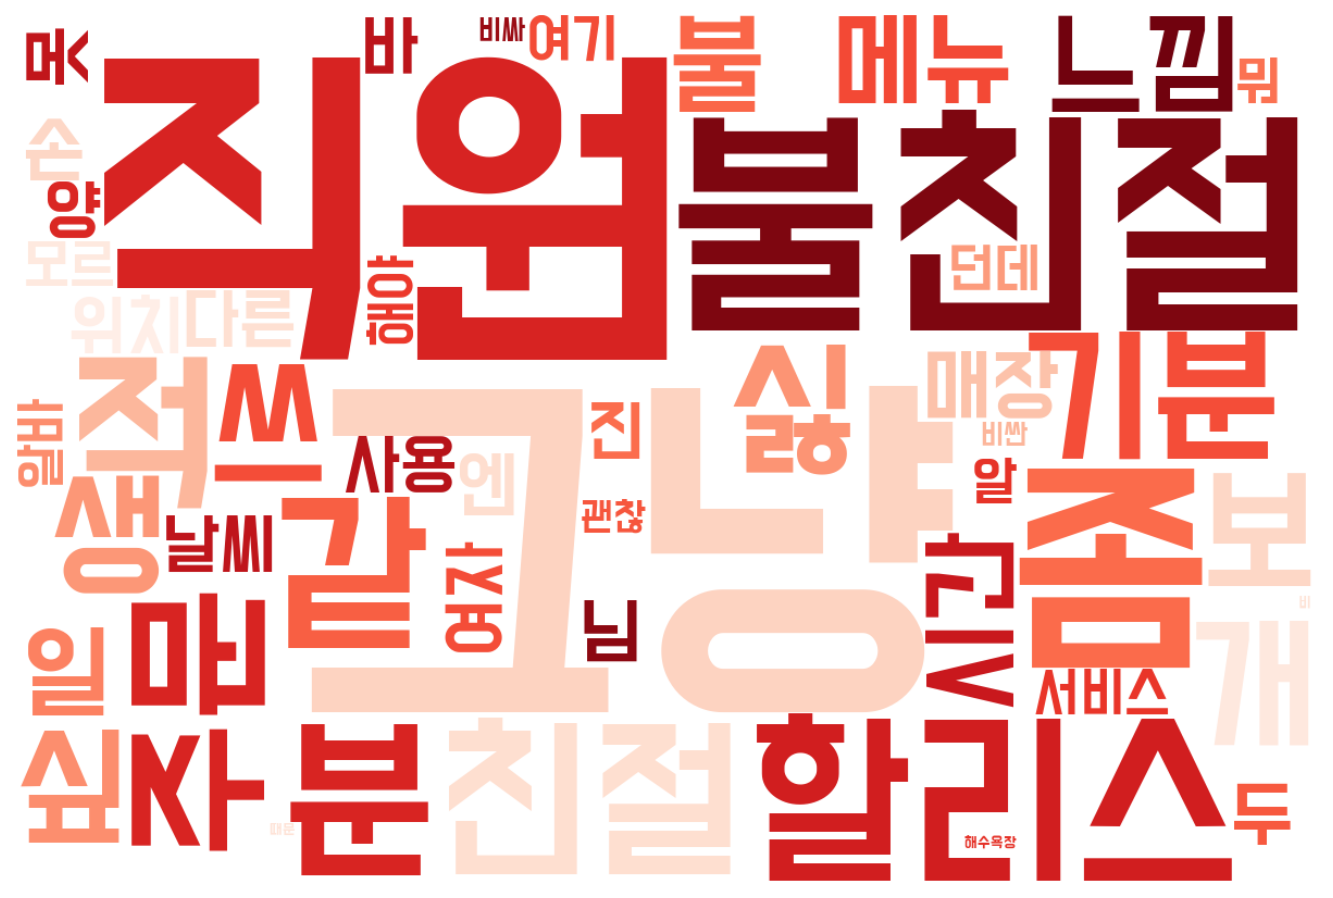

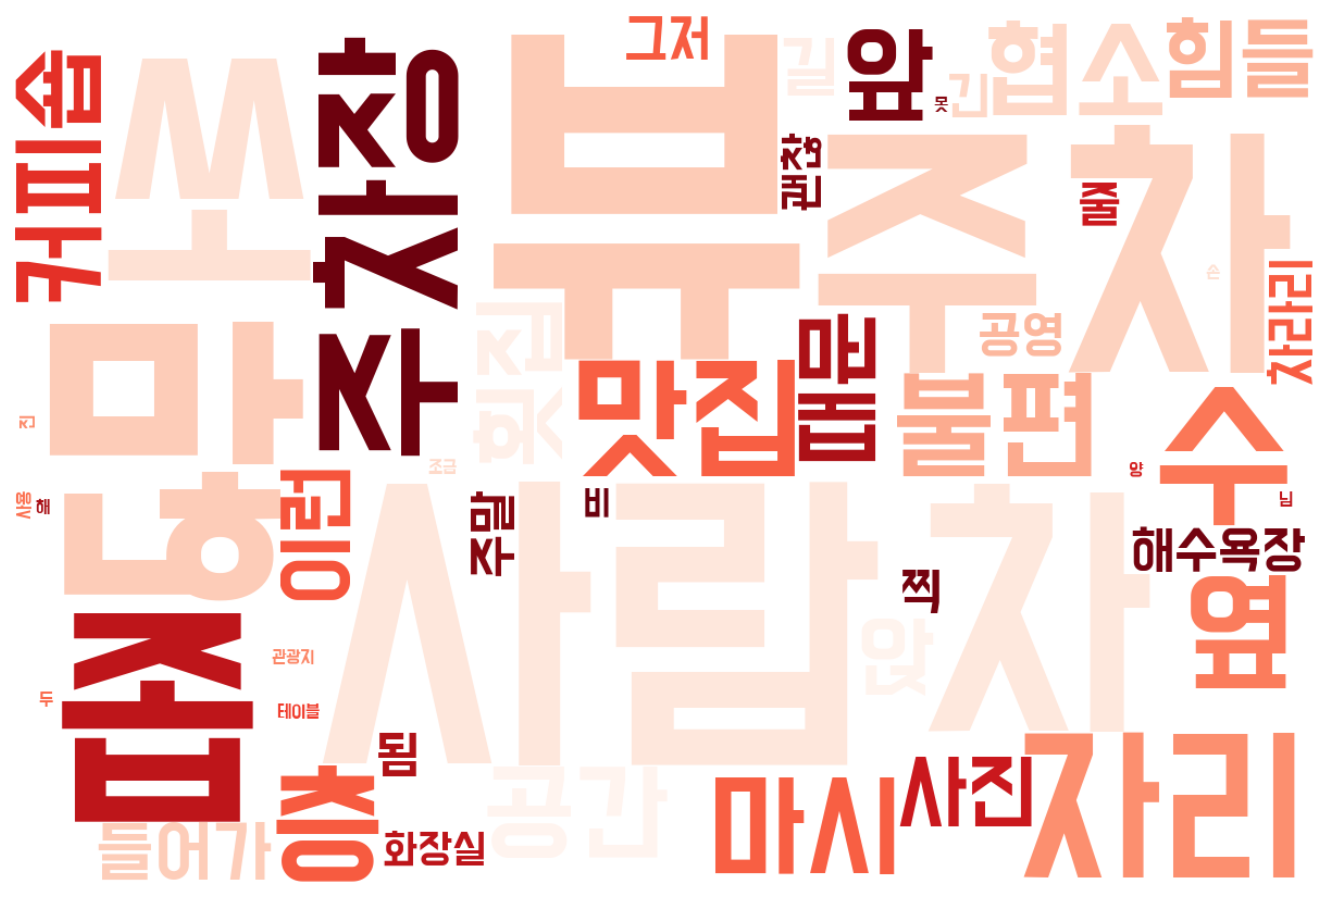

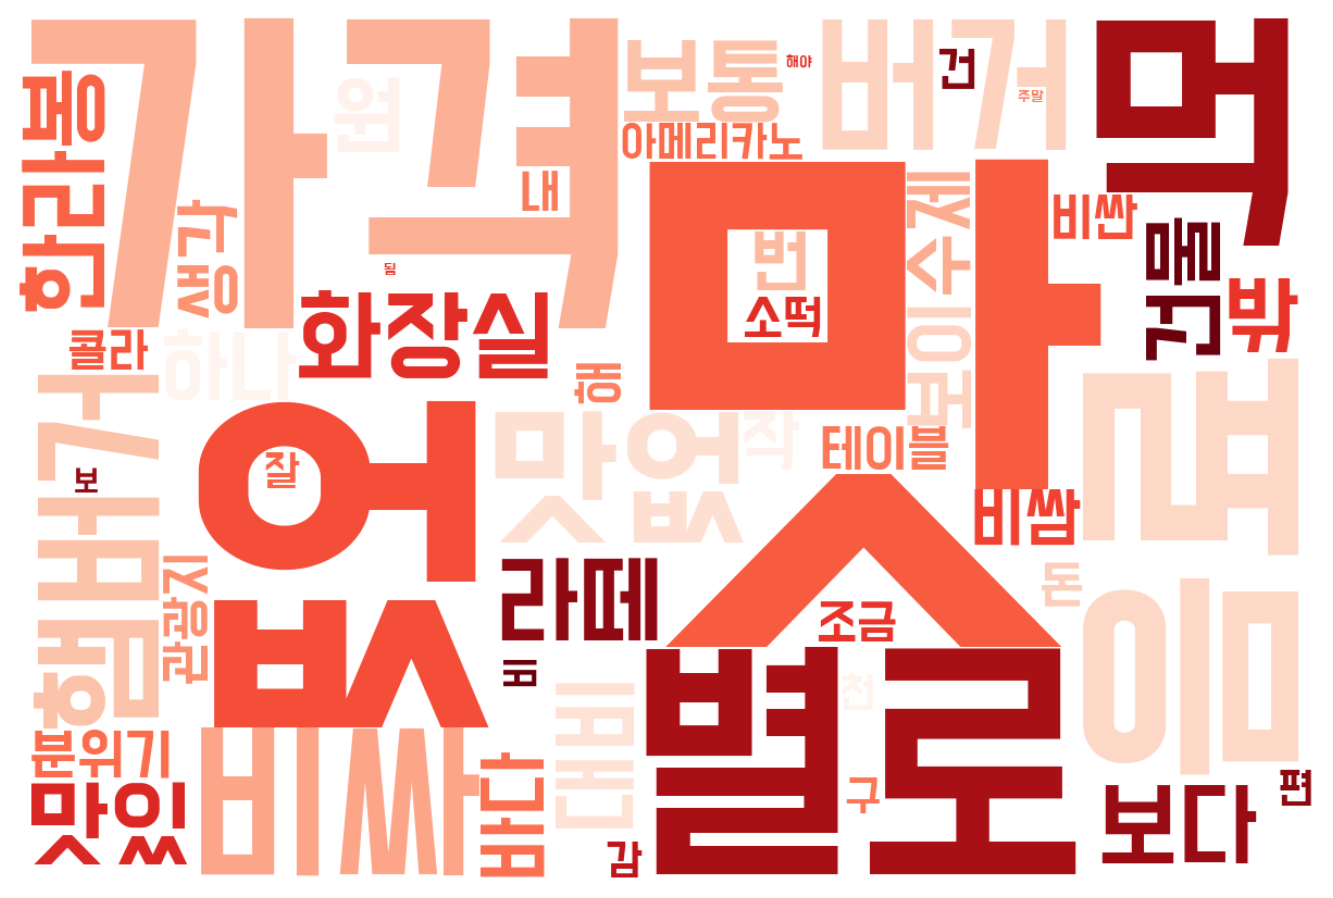

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

num_K = num_k

for i in range(num_K):
  wordcloud = WordCloud( colormap='Reds', background_color='white', width = 1200, height = 800, font_path='/content/gdrive/MyDrive/데청캠/BMDOHYEON_ttf.ttf').generate_from_frequencies( frequencies[i] )
  array = wordcloud.to_array()

  plt.figure(figsize=(12,8))
  plt.imshow(array, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  print('\n')

## 긍정어 (업로드, 다운로드 및) 전처리

In [ ]:
pos

,LABEL-1,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
0,https://lh3.googleusercontent.com/a-/AOh14Gjm9...,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.990241,긍정
2,https://lh3.googleusercontent.com/a-/AOh14Gi2L...,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.972422,긍정
4,https://lh3.googleusercontent.com/a-/AOh14GhKs...,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.604127,긍정
5,https://lh3.googleusercontent.com/a-/AOh14Gh1f...,커핀보이,지역 가이드,・리뷰 153개,1년 전,깨끗하고 바닷가상점 비해서 정감있고 뷰도 좋아요\n그에비해 가격은 착한편,카페드선유,0.937109,긍정
7,https://lh3.googleusercontent.com/a-/AOh14GhbR...,이건희,지역 가이드,・리뷰 233개,2년 전,선유도에서 깔끔하고 멋있는 카페는 여기뿐입니다,카페드선유,0.974616,긍정
...,...,...,...,...,...,...,...,...,...
1586,NaN,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.978690,긍정
1587,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351,긍정
1588,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351,긍정
1589,NaN,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.748858,긍정


In [ ]:
#불용어 제거, token화 시키기
def text_preprocessing(text_list):
    
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게','또는','및','의','로'] #불용어 설정
    stopwords = stopwords + '합니다 습니다 입니다 세요 예요 어요 네요 해서 했 았 시 는데 거 기 어요 아요 어 되 아 그 음 null nan 에서 것 면 만\
    요 는데 은데 에요 셨 할 며 함 진짜 정말 지만 인데 으로 그리고 어서 면서 라고 아서 으면 까지 인지 으나 이나 구요 카페 커피 선유도 선유 해요 넘 너무 곳 데 서 었 점 였 오 나 라\
    있 안 좋 실 갔 덜 아니 않 안 주'.split()
    tokenizer = Mecab() #형태소 분석기 
    token_list = []
    
    for content in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', str(content)) #한글이랑 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        token = [t for t in token if t not in stopwords and type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)     
    
    return token_list, tokenizer
#token_list에는 쪼개진 단어(token)들이 들어있음

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import konlpy
from konlpy.tag import Mecab
import re

In [ ]:
pos = pos['review']

In [ ]:
review_pos, mecab = text_preprocessing(pos)
review_pos = list(filter(None, review_pos))

## 토픽모델(LDA)을 이용한 긍정어 토픽 분류

In [ ]:
pip install --upgrade tomotopy

In [ ]:
import tomotopy as tp 

num_k=3

model = tp.LDAModel(k=num_k, alpha=0.1, eta=0.01, min_cf=5)
# LDAModel을 생성합니다.
# 토픽의 개수(k)는 20개, alpha 파라미터는 0.1, eta 파라미터는 0.01
# 전체 말뭉치에 5회 미만 등장한 단어들은 제거할 겁니다.
 
# 다음 구문은 input_file.txt 파일에서 한 줄씩 읽어와서 model에 추가합니다.
for i in range(len(review_pos)):
    model.add_doc(review_pos[i]) # 공백 기준으로 단어를 나누어 model에 추가합니다.
#    if i % 10 == 0: print('Document #{} has been loaded'.format(i))
 
# model의 num_words나 num_vocabs 등은 train을 시작해야 확정됩니다.
# 따라서 이 값을 확인하기 위해서 train(0)을 하여 실제 train은 하지 않고
# 학습 준비만 시킵니다.
# num_words, num_vocabs에 관심 없다면 이부분은 생략해도 됩니다.
model.train(0) 
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
# 다음 구문은 train을 총 200회 반복하면서, 
# 매 단계별로 로그 가능도 값을 출력해줍니다.
# 혹은 단순히 model.train(200)으로 200회 반복도 가능합니다.
for i in range(200):
#    print('Iteration {}\tLL per word: {}'.format(i, model.ll_per_word))
    model.train(1)
 
# 학습된 토픽들을 출력해보도록 합시다.
for i in range(model.k):
    # 토픽 개수가 총 20개이니, 0~19번까지의 토픽별 상위 단어 top_n개를 뽑아봅시다.
    res = model.get_topic_words(i, top_n=30)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))
print('perplexity:',model.perplexity)

# Use fequency of the word as weight
frequencies = list(np.zeros(num_k))
df_frequencies = list(np.zeros(num_k))
for i in range(num_k):
  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
  b = pd.DataFrame(model.get_topic_words(i,50))
  df_frequencies[i] = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
  df_frequencies[i].columns=['words','fq']
  frequencies[i] = df_frequencies[i].set_index('words').to_dict()['fq']

# frequency sum for each topic
for i in range(num_k):
  print(f'frequency sum for the {i}th topic words:',sum(frequencies[i].values()))

Total docs: 1041
Total words: 4420
Vocab size: 274
Topic #0	굿, 많, 맛, 뷰, 사람, 가격, 사진, 같, 인테리어, 좁, 실내, 생각, 찍, 주문, 적, 여기, 원, 보다, 방문, 앞, 느낌, 겠, 깔끔, 많이, 긴, 위치, 밖, 어용, 대, 던
Topic #1	바다, 보, 주차, 경치, 수, 층, 자리, 전망, 시간, 없, 시원, 괜찮, 보이, 주차장, 풍경, 같, 분, 공간, 건물, 앞, 무료, 잔, 마시, 차, 조금, 한잔, 테라스, 앉, 좀, 날
Topic #2	맛있, 뷰, 친절, 분위기, 맛, 맛집, 먹, 음료, 님, 잘, 사장, 라떼, 버거, 버스, 수제, 최고, 햄버거, 호떡, 니, 짱, 예쁘, 맛나, 한라봉, 추천, 직원, 더, 엄청, 아주, 또, 비싸
perplexity: 222.2399632926688
frequency sum for the 0th topic words: 1083.0
frequency sum for the 1th topic words: 1113.0
frequency sum for the 2th topic words: 1549.0


In [ ]:
# (Optional) Use probability of the word in the topic as weight
df = list(np.zeros(num_k))
for i in range(num_k):
  df[i] = pd.DataFrame(model.get_topic_words(i,50))
  frequencies[i] = df[i].set_index(0).to_dict()[1]

In [ ]:
# Save words and its probability in the topic as csv
#for i in range(num_k):
#  df[i].to_csv(f'df_pos_topic_prob_50_{i}.csv')

In [ ]:
# Load words and its probability in the topic as csv
#for i in range(num_k):
#  frequencies[i] = pd.read_csv(f'df_pos_topic_prob_50_{i}.csv').set_index('0').to_dict()['1']

In [ ]:
# (Optional) Use geomean of fequency and probability of the word in the topic as weight
#df = list(np.zeros(num_k))
#for i in range(num_k):
#  df[i] = pd.merge(df_frequencies[i],pd.DataFrame(model.get_topic_words(i,50)),'inner',left_on='words',right_on=0).drop(0,axis=1) # DataFrame [words, frequency, probability in the topic]
#  df[i]['geomean']=(df[i]['fq']*df[i][1])**0.5
#  frequencies[i] = df[i].set_index('words').to_dict()['geomean']

In [ ]:
# words and its probability in the topic -> DataFrame -> csv

#for i in range(4):
#  pd.DataFrame(model.get_topic_words(i,100)).to_csv(f'df_topic_prob_{i}_pos_100.csv')

In [ ]:
#save 100 words and frequencies for each topic

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,100))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_pos_100.csv')

In [ ]:
# save 50 words and frequencies for each topic (better than 100)

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,50))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_pos.csv')

In [ ]:
# word frequency in positive words 기준 df 가졍오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic{i}_pos.csv').set_index('words').to_dict()['fq']

In [ ]:
# probability in the topic 기준 df 가져오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic_prob_{i}_pos_100.csv').set_index('0').to_dict()['1']

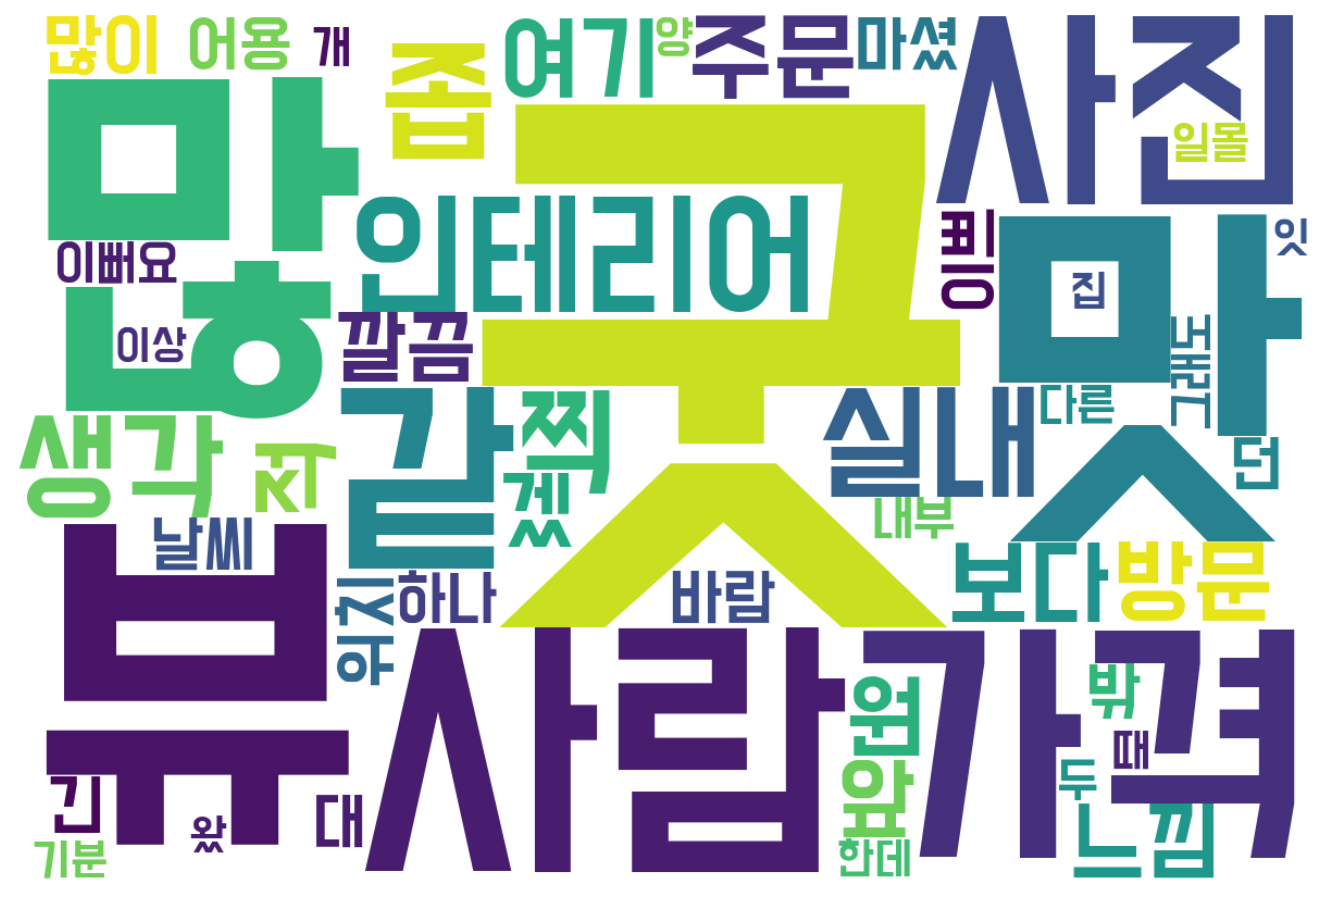

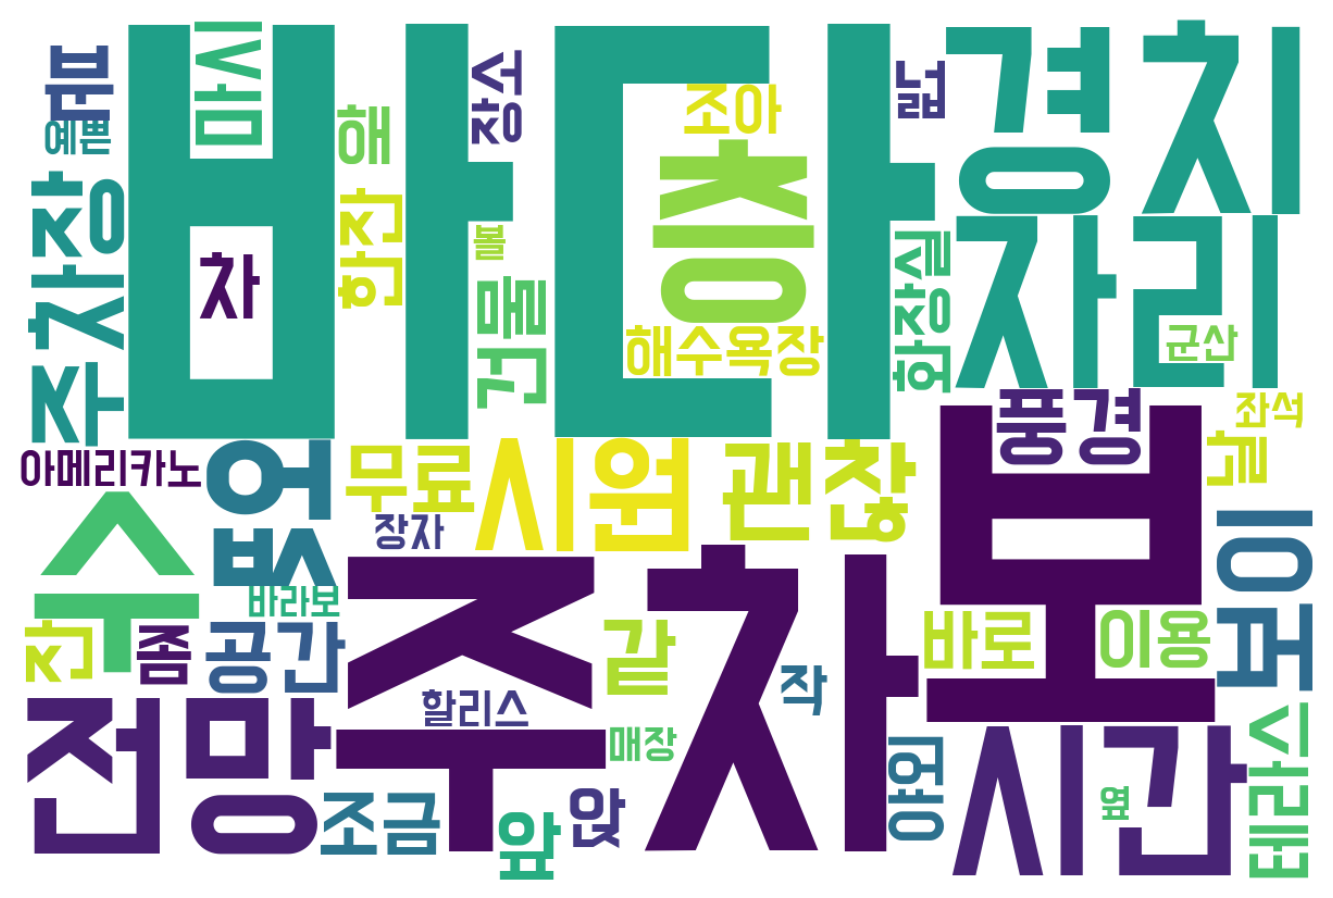

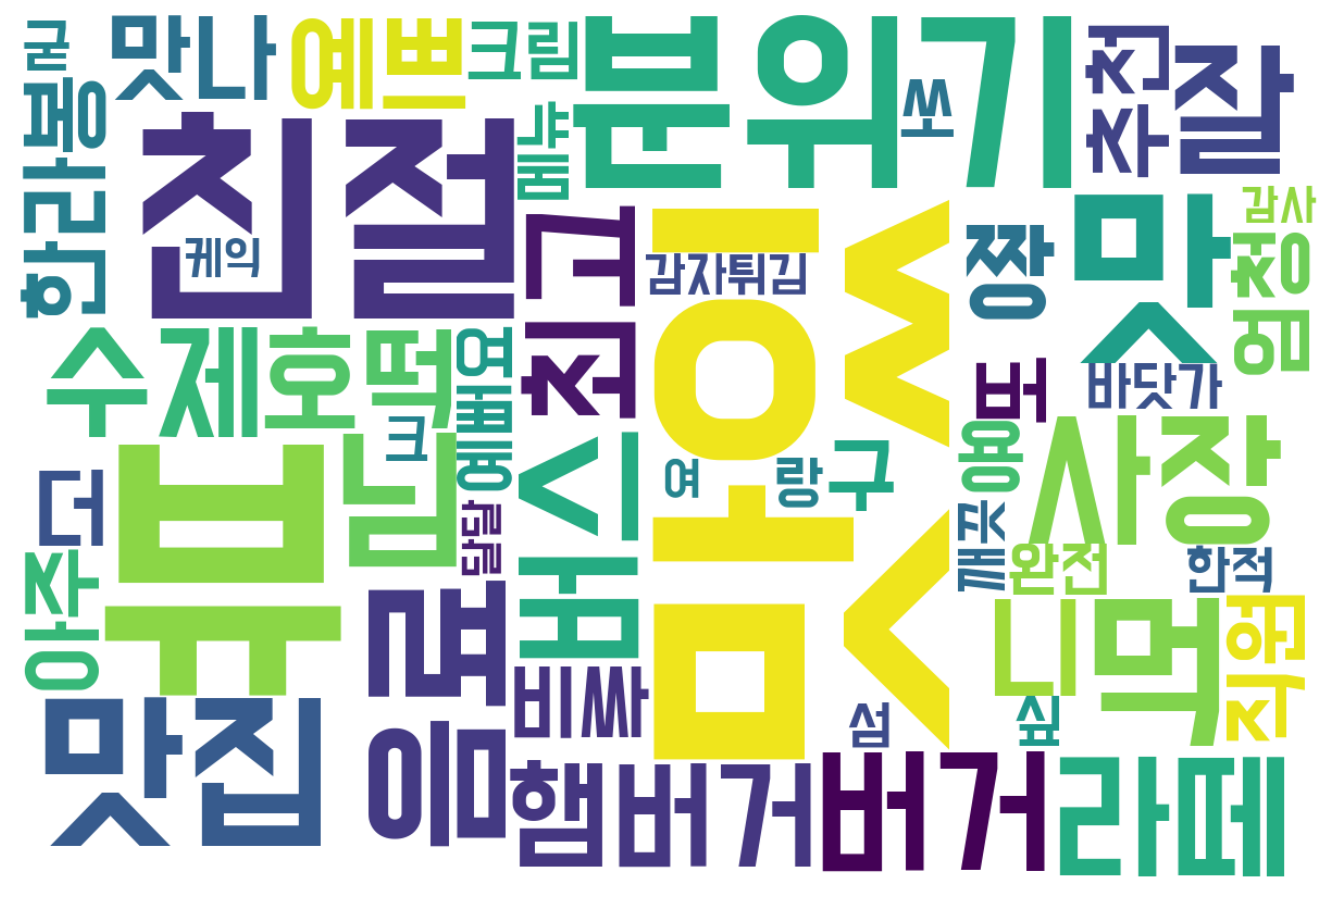

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

num_K = num_k

for i in range(num_K):
  wordcloud = WordCloud( background_color='white', width = 1200, height = 800, font_path='/content/gdrive/MyDrive/데청캠/BMDOHYEON_ttf.ttf').generate_from_frequencies( frequencies[i] )
  array = wordcloud.to_array()

  plt.figure(figsize=(12,8))
  plt.imshow(array, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  print('\n')